In [10]:
# Basics
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Sklearn
from sklearn.preprocessing import StandardScaler, Imputer 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.metrics import make_scorer
# xgboost
import xgboost as xgb
# Our custom modules
sys.path.append('..')
from anrg.pipeline import Pipeline # my customized Pipeline
from anrg.blending import BlendedRegressor
from anrg.cleaning import TargetThresholdFilter, LogPlusOne
##### setting #######
pd.set_option('display.max_columns', 500)  # force pandas to display all columns for better visual inspection
%matplotlib inline

In [11]:
trn = pd.read_csv('../data/train.csv')
# trn = pd.read_csv('../data/train_10.csv', index_col=0)  # column #0 in our file is DataFrame index
# trn = pd.read_csv('../data/train_1.csv', index_col=0)

In [12]:
t = time.time()
trn_withRef = trn[trn['Ref'].notnull()]
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 0.8777 secs


In [13]:
# Combine observations by 'Id', aggregate features
t = time.time()
trn_withRef_comb = trn_withRef.groupby('Id').agg(['mean','std','median','count','min', 'max'])
trn_withRef_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(trn_withRef_comb.columns.values)]
trn_withRef_comb = trn_withRef_comb.drop(['Expected_count', 'Expected_median', 'Expected_std', 'Expected_min','Expected_max'], axis =1)
print 'Time elapsed: {:.4f} secs'.format(time.time()-t)  # toc

Time elapsed: 10.0305 secs


In [14]:
X = trn_withRef_comb.loc[:, 'minutes_past_mean':'Kdp_5x5_90th_max']  # NOTE: used range slicing on column
y = trn_withRef_comb['Expected_mean']
print X.shape, y.shape

(731556, 132) (731556,)


In [30]:
ttf = TargetThresholdFilter(threshold=45)
lpo = LogPlusOne()
imp = Imputer(strategy='median', copy=False)  # Get a imputor with column-mean filling config
ss = StandardScaler(copy=False, with_mean=True, with_std=True)
clf = Ridge(alpha=2.0)
pip = Pipeline([('ttf',ttf), ('lpo',lpo), ('imp',imp), ('ss',ss), ('clf',clf)])  # a Pipeline wrapper to chain'em up
def LogPlusOne_score(ground_truth, predictions, lpo=lpo):
    return np.float64(np.mean(np.abs(ground_truth - (np.power(10, predictions) - 1))))
scorer = make_scorer(LogPlusOne_score, greater_is_better=True)  # define scoring metric

# CV

In [31]:
scores = cross_val_score(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, verbose=2)

[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  20.4s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  18.7s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  16.6s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  14.5s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  21.6s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  18.5s
[CV] no parameters to be set .........................................
[CV] ................................ no parameters to be set -  21.5s
[CV] n

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.2min finished


In [17]:
print np.mean(scores), np.std(scores)
pip

23.2664903075 1.58167881735


Pipeline(steps=[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [32]:
print np.mean(scores), np.std(scores)
pip

23.2664899853 1.58167932924


Pipeline(steps=[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', Ridge(alpha=2.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [28]:
# Sweep parameter
param_name, param_range='clf__alpha', np.arange(1.5, 2.6, 0.1)
train_scores, test_scores= validation_curve(estimator=pip, X=X, y=y, scoring=scorer, cv=10, n_jobs=1, 
                          param_name=param_name, param_range=param_range, verbose=2)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

[CV] clf__alpha=1.5 ..................................................
[CV] ......................................... clf__alpha=1.5 -  12.0s
[CV] clf__alpha=1.6 ..................................................
[CV] ......................................... clf__alpha=1.6 -  12.0s
[CV] clf__alpha=1.7 ..................................................
[CV] ......................................... clf__alpha=1.7 -  12.0s
[CV] clf__alpha=1.8 ..................................................
[CV] ......................................... clf__alpha=1.8 -  12.0s
[CV] clf__alpha=1.9 ..................................................
[CV] ......................................... clf__alpha=1.9 -  12.0s
[CV] clf__alpha=2.0 ..................................................
[CV] ......................................... clf__alpha=2.0 -  12.0s
[CV] clf__alpha=2.1 ..................................................
[CV] ......................................... clf__alpha=2.1 -  12.0s
[CV] c

[Parallel(n_jobs=1)]: Done  40 tasks       | elapsed: 11.1min
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed: 34.9min finished


[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]
[0.1, 0.5, 1, 5, 10, 50, 100]
[ 23.26535698  23.26535788  23.26535864  23.26536262  23.26536628
  23.26539081  23.26542045]
[ 23.26649333  23.26649113  23.26649031  23.26649139  23.26649415
  23.26651502  23.26654081]


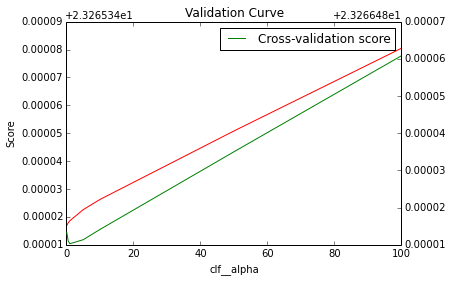

In [25]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# Sweep alpha = [0.1, 0.5, 1, 5, 10, 50, 100]
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', Ridge(alpha=1.4999999999999998, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001))]
[ 0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5]
[ 23.26535788  23.26535805  23.26535821  23.26535836  23.2653585
  23.26535864  23.26535878  23.26535891  23.26535904  23.26535917
  23.26535929]
[ 23.26649113  23.26649088  23.26649069  23.26649053  23.26649041
  23.26649031  23.26649023  23.26649016  23.26649011  23.26649007
  23.26649004]


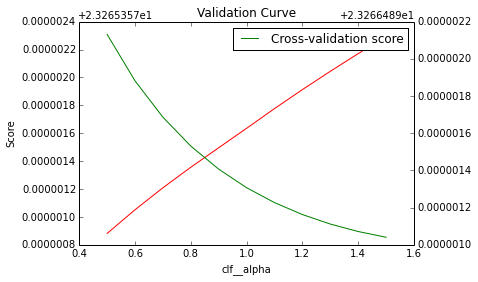

In [27]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# Sweep alpha = np.arange(0.5, 1.6, 0.1)
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

[('ttf', TargetThresholdFilter(threshold=45)), ('lpo', LogPlusOne()), ('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', Ridge(alpha=2.5000000000000009, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001))]
[ 1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5]
[ 23.26535929  23.26535941  23.26535953  23.26535965  23.26535976
  23.26535987  23.26535997  23.26536008  23.26536018  23.26536029
  23.26536039]
[ 23.26649004  23.26649002  23.26649     23.26648999  23.26648999
  23.26648999  23.26648999  23.26649002  23.26649006  23.2664901
  23.26649014]


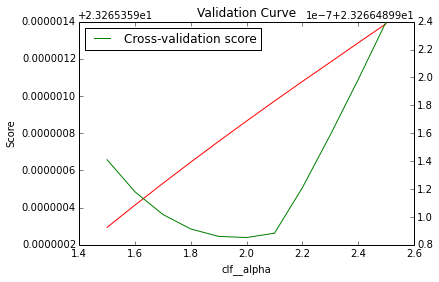

In [29]:
# Plotting the validation curver, i.e. trn/val error versus parameter value
# Sweep alpha = np.arange(0.5, 1.6, 0.1)
# 100% data
print pip.get_params()['steps']
print param_range
print train_scores_mean
print test_scores_mean
plt.title("Validation Curve")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
# plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.twinx()
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")
# plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

# Generate submission

In [28]:
pip.fit(X, y)

Pipeline(steps=[('imp', Imputer(axis=0, copy=False, missing_values='NaN', strategy='median',
    verbose=0)), ('ss', StandardScaler(copy=False, with_mean=True, with_std=True)), ('clf', XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, m...g:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1))])

In [32]:
test = pd.read_csv('../data/test.csv')
test_withRef = test[test['Ref'].notnull()]
test_withRef_comb = test_withRef.groupby('Id').agg(['mean','std','median','count','min', 'max'])
test_withRef_comb.columns = ['_'.join(tup) for (i,tup) in enumerate(test_withRef_comb.columns.values)]
test_X = test_withRef_comb.loc[:, 'minutes_past_mean':'Kdp_5x5_90th_max']  # NOTE: used range slicing on column
test_y_predict = 10**pip.predict(X=test_X)-1

In [33]:
# Ref-samples
test_result_withRef = pd.DataFrame()
test_result_withRef['Id'] = test_withRef_comb.index
test_result_withRef['Expected'] = test_y_predict
# All-samples
test_result = pd.DataFrame()
test_result['Id'] = test['Id'].unique()
# Merge and set Non-Ref samples to -1
test_result = pd.merge(test_result, test_result_withRef, how='left', on=['Id'], sort=True)
test_result.loc[test_result['Expected'].isnull(), 'Expected'] = -1
# Write file
datetime_str = time.strftime('%Y%m%d_%H%M%S')
test_result.to_csv('../data/result_'+datetime_str+'.csv', index=False)
print '../data/result_'+datetime_str+'.csv'

../data/result_20151121_124706.csv
